# Compare putative IESs with haplotypes

Visual inspection of mapped reads at putative "IESs" predicted by BleTIES showed that presence of these "IESs" often correlated with SNPs on the same reads. We wish to examine this systematically by checking correlation of "IES" indels with read haplotags.

In [1]:
import pysam
import re
import json
import pybedtools

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from Bio import SeqIO

In [2]:
# Import haplotagged BAM mapping
bamfile = '/tmp/global2/kbseah/bleties/minimap2.comb.LmagMAC.rg_tag.diploid.g400.haplotagged.bam'
sam = pysam.AlignmentFile(bamfile, 'rb')

In [3]:
OP2BAM = {'M': 0, 'I': 1, 'D': 2, 'N': 3, 'S': 4, 'H': 5, 'P': 6, '=': 7, 'X':8}
BAM2OP = {OP2BAM[op] : op for op in OP2BAM}
QUERY_CONSUMING = [0, 1, 4, 7, 8]
REF_CONSUMING = [0, 2, 3, 7, 8]

def get_op_ref_pos(reftargetpos, refstartpos, cigartuples):
    # reftargetpos and refstartpos are zero-based
    # however, zero-length features in zero-based numbering 
    # are to the LEFT of the coordinate
    # cigartuples is output from pysam.AlignedSegment.cigartuples
    curr_int_start = refstartpos
    curr_int_end = refstartpos
    for bamop, oplen in cigartuples:
        if bamop in REF_CONSUMING:
            # ref consuming, move forward on ref
            curr_int_start = curr_int_end
            curr_int_end = curr_int_end + oplen
            if reftargetpos >= curr_int_start and reftargetpos < curr_int_end:
                return(oplen, BAM2OP[bamop])
        else:
            # current operation has extent zero
            curr_int_start = curr_int_end 
            if reftargetpos == curr_int_end:
                return(oplen, BAM2OP[bamop])

Example: contig `000001F` positions 441488 to 442329 (inclusive)

At this position, MILRAA calls a deletion of 842 bp.

We extract the `HP` (haplotype) tag for all reads that map to this position, and show that the haplotype of a given read correlates with the presence of the indel. However, because haplotypes were called separately for MIC vs MAC read groups (`RG` tag), the numbering sometimes conflicts.

In [4]:
iter = sam.fetch("000001F", 441488, 442329)
outtab = []
for x in iter:
    ops = get_op_ref_pos(441488, x.reference_start, x.cigartuples)
    if ops:
        outtab.append([str(i) for i in [ops[0], ops[1], x.get_tag('HP'), x.get_tag('RG')]])

In [5]:
outtab = pd.DataFrame(outtab, columns=['oplen','op','hp','rg'])

In [6]:
outtab.query('rg=="mic"').groupby('op')['hp'].value_counts()

op  hp
D   2     12
M   1     11
Name: hp, dtype: int64

In [7]:
outtab.groupby(['rg','op'])['hp'].value_counts()

rg   op  hp
mac  D   1     13
     M   2     22
         1      2
mic  D   2     12
     M   1     11
Name: hp, dtype: int64

In [8]:
# import IES features from GFF file
mac_ies_gff_file = '../bleties/LmagMAC.LmagMAC.milraa_ies_fuzzy.no_overlap_repeats.gff3'
mac_ies_features = pybedtools.BedTool(mac_ies_gff_file)

mic_ies_gff_file = '../bleties/LmagMIC.LmagMAC.milraa_ies_fuzzy.no_overlap_repeats.gff3'
mic_ies_features = pybedtools.BedTool(mic_ies_gff_file)

#ies_gff_file_test = 'mic.milraa.flye-comb_LmagMAC.milraa_ies_fuzzy.no_overlap_repeats.scaffold_291.gff3'
#ies_features_test = pybedtools.BedTool(ies_gff_file_test)

In [9]:
def get_ies_reads_haplotag(ies, sam, min_average_cov=10, max_average_cov=20):
    """
    Get haplotags of reads with and without a given putative indel
    
    Putative "IESs" may turn out to be allelic variants. To help diagnose this, 
    this function takes the IESs reported by BleTIES MILRAA and mapped reads
    haplotagged with WhatsHap, and reports the haplotag of reads with and
    without the "IES" indel. If they are allelic in origin, then the indel
    should mostly correlate with the haplotag.
    
    Parameters
    ----------
    ies : pybedtools.cbedtools.Interval
        IES interval from BleTIES MILRAA (ccs mode). Must contain attributes:
        `cigar`, `average_coverage`
    sam : pysam.libcalignmentfile.AlignmentFile
        Pysam object representing mapped, haplotagged reads, containing RG and HP tags
    min_average_cov : int
    max_average_cov : int
        Min and max values of average_coverage attribute in IES feature to accept. Values
        outside this range are considered to be coverage anomalies
        
    Returns
    -------
    dict
        key1 - read group tag (RG) from BAM file
        key2 - 'with' or 'without', i.e. whether given read contains putative IES indel
        value - list of haplotype tags (HP) from BAM file for each read belonging to the 
          given read group and IES presence/absence, otherwise 0 if read not haplotagged
    """
    hp = defaultdict(lambda: defaultdict(list))
    # Exclude coverage anomalies
    if int(ies.attrs['average_coverage']) <= max_average_cov \
      and int(ies.attrs['average_coverage']) >= min_average_cov:
        if ies.fields[2] == 'internal_eliminated_sequence_junction':
            # zero-length feature, junction is to the LEFT of reftargetpos
            reftargetpos = ies.end
        elif ies.fields[2] == 'internal_eliminated_sequence':
            # finite-length feature, start is reftargetpos
            reftargetpos = ies.start
        # get cigars representing the indel
        cigs = ies.attrs['cigar'].split(' ')
        # split cigar from coverage
        cigs = {i.split("*")[0]:i.split("*")[1] for i in cigs}
        # get reads mapping to target location
        iter = sam.fetch(ies.chrom, ies.start, ies.stop)
        for read in iter:
            ops = get_op_ref_pos(reftargetpos, read.reference_start, read.cigartuples)
            if not read.is_secondary and not read.is_supplementary:
                if ops:
                    ops_string = str(ops[0]) + str(ops[1])
                    if ops_string in cigs:
                        if read.has_tag('HP'):
                            hp[read.get_tag('RG')]['with'].append(read.get_tag('HP'))
                        else:
                            hp[read.get_tag('RG')]['with'].append(0)
                    else:
                        if read.has_tag('HP'):
                            hp[read.get_tag('RG')]['without'].append(read.get_tag('HP'))
                        else:
                            hp[read.get_tag('RG')]['without'].append(0)
        return(hp)

# Plot fraction of indel +/- reads with haplotag 1 vs. 2

In [10]:
def compare_haplotags_with_without(ies_features, sam, rg):
    """
    Tabulate haplotags for reads with/without putative IES indels
    
    Haplotags have the following values: 0 (untagged), 1, 2.
    
    The output is used to determine whether putative IES features are
    actually correlated with SNP haplotypes.
    
    Parameters
    ----------
    ies_features : pybedtools.bedtool.BedTool
        IES feature table in GFF format produced by BleTIES MILRAA (CCS mode)
        and imported with pybedtools
    sam : pysam.libcalignmentfile.AlignmentFile
        Pysam object representing mapped, haplotagged reads, containing RG and HP tags
    rg : str
        Which read group (RG tag) to process
        
    Returns
    -------
    pd.DataFrame
        With the following columns:
         - bpid : IES identifier (ID field from GFF)
         - indel : Status, either 'with' or 'without' putative IES indel
         - notag : Number of reads with no haplotag
         - tag1 : Number of reads tagged as haplotype 1
         - tag2 : Number of reads tagged as haplotype 2
    """
    tbl = []
    for ies in ies_features:
        hp = get_ies_reads_haplotag(ies, sam, min_average_cov=5, max_average_cov=20)
        if hp:
            hp_with = []
            hp_without = []
            #for rg in hp:
            if rg in hp:
                hp_with.extend(hp[rg]['with'])
                hp_without.extend(hp[rg]['without'])
            out1 = [ies.name,
                   'with',
                   len([i for i in hp_with if i == 0]),
                   len([i for i in hp_with if i == 1]),
                   len([i for i in hp_with if i == 2])]
            out2 = [ies.name,
                   'without',
                   len([i for i in hp_without if i == 0]),
                   len([i for i in hp_without if i == 1]),
                   len([i for i in hp_without if i == 2])]
            tbl.append(out1)
            tbl.append(out2)
    tbl_df = pd.DataFrame(tbl, columns=['bpid','indel','notag','tag1','tag2'])
    return(tbl_df)

In [11]:
tbl_mac_df = compare_haplotags_with_without(mac_ies_features, sam, 'mac')
tbl_mac_df['sum_tag'] = tbl_mac_df['tag1'] + tbl_mac_df['tag2']
tbl_mac_df['tag1_frac'] = tbl_mac_df['tag1'] / tbl_mac_df['sum_tag']

<AxesSubplot:>

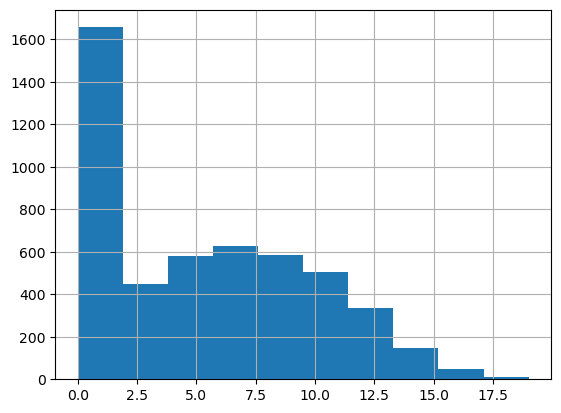

In [16]:
# Check the distribution of coverage values for haplotagged reads spanning putative IESs
# to determine a suitable cutoff
tbl_mac_df['sum_tag'].hist()

In [18]:
tbl_mic_df = compare_haplotags_with_without(mic_ies_features, sam, 'mic')
tbl_mic_df['sum_tag'] = tbl_mic_df['tag1'] + tbl_mic_df['tag2']
tbl_mic_df['tag1_frac'] = tbl_mic_df['tag1'] / tbl_mic_df['sum_tag']
#tbl_mic_df_pivot = tbl_mic_df.pivot(index='bpid', columns='indel',values='tag1_frac').reset_index()

<AxesSubplot:>

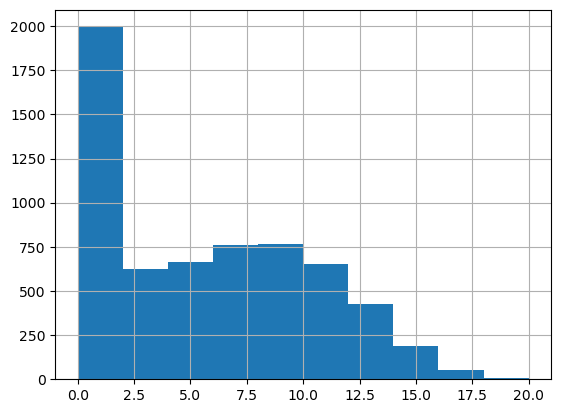

In [19]:
# Check the distribution of coverage values for haplotagged reads spanning putative IESs
# to determine a suitable cutoff
tbl_mic_df['sum_tag'].hist()

In [20]:
# Pivot to summarize haplotype ratio per indel for reads with vs. without indel
# Filter out indels with low coverage

# MAC
tbl_mac_df_pivot = pd.DataFrame(
    tbl_mac_df.pivot(index='bpid', columns='indel', values=['sum_tag','tag1_frac']).to_records()
)
# Rename columns
tbl_mac_df_pivot.columns = ['bpid','sum_tag_with','sum_tag_without','tag1_frac_with','tag1_frac_without']

# MIC
tbl_mic_df_pivot = pd.DataFrame(
    tbl_mic_df.pivot(index='bpid', columns='indel', values=['sum_tag','tag1_frac']).to_records()
)
# Rename columns
tbl_mic_df_pivot.columns = ['bpid','sum_tag_with','sum_tag_without','tag1_frac_with','tag1_frac_without']

In [21]:
tbl_mac_df_pivot.head()

,bpid,sum_tag_with,sum_tag_without,tag1_frac_with,tag1_frac_without
0,BREAK_POINTS_000001F_1696593_1696622_30,8.0,8.0,1.0,0.0
1,BREAK_POINTS_000001F_2025631_2025631_19,8.0,11.0,1.0,0.0
2,BREAK_POINTS_000001F_2322016_2322033_18,7.0,10.0,0.0,0.9
3,BREAK_POINTS_000002F_119950_119950_178,7.0,9.0,0.0,1.0
4,BREAK_POINTS_000002F_120591_120615_25,7.0,9.0,0.0,1.0


In [22]:
tbl_mac_df.head()

,bpid,indel,notag,tag1,tag2,sum_tag,tag1_frac
0,BREAK_POINTS_FUZZY_000001F_1694150_1694150_56.5,with,0,9,0,9,1.000000
1,BREAK_POINTS_FUZZY_000001F_1694150_1694150_56.5,without,0,1,10,11,0.090909
2,BREAK_POINTS_000001F_1696593_1696622_30,with,0,8,0,8,1.000000
3,BREAK_POINTS_000001F_1696593_1696622_30,without,0,0,8,8,0.000000
4,BREAK_POINTS_000001F_2025631_2025631_19,with,0,8,0,8,1.000000


In [23]:
print("Total putative IESs annotated:")
print(len(mac_ies_features))
print("No. putative IESs covered by haplotagged MAC reads:")
print(int(len(tbl_mac_df)/2)) # divide by two because there are two rows for each indel
print("No. putative IESs with >2 haplotagged reads per haplotype spanning:")
print(tbl_mac_df_pivot.query('sum_tag_with > 2 and sum_tag_without > 2').shape[0])

Total putative IESs annotated:
12897
No. putative IESs covered by haplotagged MAC reads:
2472
No. putative IESs with >2 haplotagged reads per haplotype spanning:
1294


In [24]:
print("Total putative IESs annotated:")
print(len(mic_ies_features))
print("No. putative IESs covered by haplotagged MIC reads:")
print(int(len(tbl_mic_df)/2)) # divide by two because there are two rows for each indel
print("No. putative IESs with >2 haplotagged reads per haplotype spanning:")
print(tbl_mic_df_pivot.query('sum_tag_with > 2 and sum_tag_without > 2').shape[0])

Total putative IESs annotated:
13734
No. putative IESs covered by haplotagged MIC reads:
3068
No. putative IESs with >2 haplotagged reads per haplotype spanning:
1626


In [25]:
(tbl_mac_df_pivot.query('sum_tag_with > 2 and sum_tag_without > 2').query('tag1_frac_with >=0.9 and tag1_frac_without <=0.1').shape[0]
 + tbl_mac_df_pivot.query('sum_tag_with > 2 and sum_tag_without > 2').query('tag1_frac_without >=0.9 and tag1_frac_with <=0.1').shape[0]) / tbl_mac_df_pivot.query('sum_tag_with > 2 and sum_tag_without > 2').shape[0]

0.7047913446676971

In [26]:
(tbl_mic_df_pivot.query('sum_tag_with > 2 and sum_tag_without > 2').query('tag1_frac_with >=0.9 and tag1_frac_without <=0.1').shape[0]
 + tbl_mic_df_pivot.query('sum_tag_with > 2 and sum_tag_without > 2').query('tag1_frac_without >=0.9 and tag1_frac_with <=0.1').shape[0]) / tbl_mic_df_pivot.query('sum_tag_with > 2 and sum_tag_without > 2').shape[0]

0.6340713407134071

# Visualize correlation of indels with haplotypes

For each indel site, plot the fraction of haplotype-1 reads with the indel vs. the fraction without the indel. If indels and haplotypes are perfectly correlated, then either 100% of reads with the indel are haplotype 1, or 100% of reads with the indel are haplotype 2. 

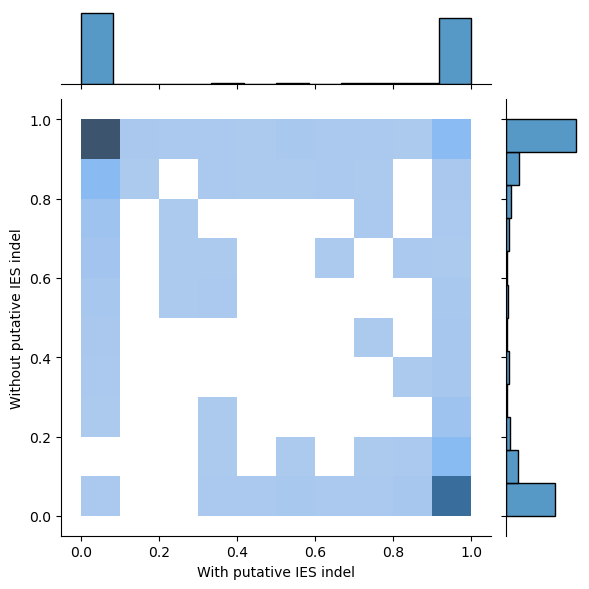

In [27]:
sns.jointplot(
    data=tbl_mac_df_pivot.query('sum_tag_with > 2 and sum_tag_without > 2'),
    x='tag1_frac_with', y='tag1_frac_without', kind='hist', binwidth=0.1)
plt.xlabel("With putative IES indel")
plt.ylabel("Without putative IES indel")
plt.savefig('plots/putative_ies.mac_reads.vs.mac_asm_haplotag_ratios.png')
plt.savefig('plots/putative_ies.mac_reads.vs.mac_asm_haplotag_ratios.pdf')

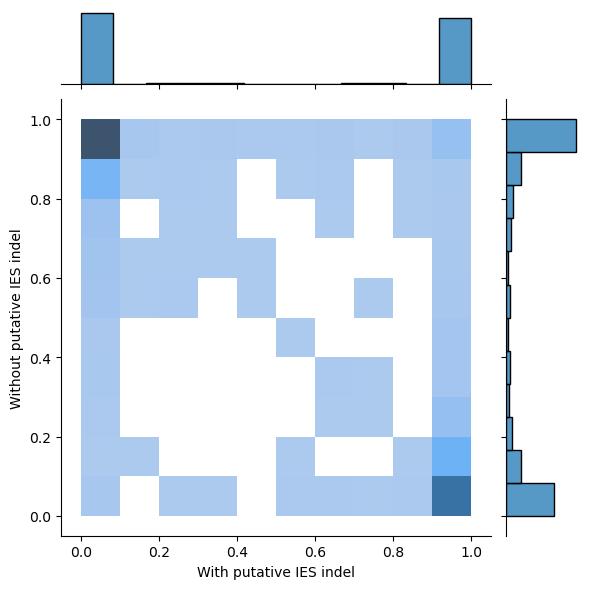

In [28]:
sns.jointplot(
    data=tbl_mic_df_pivot.query('sum_tag_with > 2 and sum_tag_without > 2'), 
    x='tag1_frac_with', y='tag1_frac_without', kind='hist', binwidth=0.1)
plt.xlabel("With putative IES indel")
plt.ylabel("Without putative IES indel")
plt.savefig('plots/putative_ies.mic_reads.vs.mic_asm_haplotag_ratios.png')
plt.savefig('plots/putative_ies.mic_reads.vs.mic_asm_haplotag_ratios.pdf')

In [29]:
tbl_mic_df.query('bpid=="BREAK_POINTS_000003F_841992_841992_47"')

,bpid,indel,notag,tag1,tag2,sum_tag,tag1_frac
32,BREAK_POINTS_000003F_841992_841992_47,with,0,0,3,3,0.0
33,BREAK_POINTS_000003F_841992_841992_47,without,0,6,6,12,0.5


Inspect a few IESs manually

In [30]:
for ies in mac_ies_features[0:100]:
    #print(ies.name)
    hp = get_ies_reads_haplotag(ies, sam, min_average_cov=5, max_average_cov=20)
    if hp:
        print(ies.name)
        for k1 in hp:
            print (k1)
            for k2 in hp[k1]:
                print("  " + k2 + " " + " ".join([str(i) for i in hp[k1][k2]]))
        print("")

BREAK_POINTS_FUZZY_000001F_1694150_1694150_56.5
mac
  with 1 1 1 1 1 1 1 1 1
  without 2 2 1 2 2 2 2 2 2 2 2
mic
  with 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  without 1 2 1 1 1 1 1 1 1 1 1 1 1 1

BREAK_POINTS_000001F_1696593_1696622_30
mac
  with 1 1 1 1 1 1 1 1
  without 2 2 2 2 2 2 2 2
mic
  without 1 2 1 1 1 1 1 1 1 1 1 1 1 1
  with 2 2 2 2 2 2 2 2 2 2 2 2

BREAK_POINTS_000001F_2025631_2025631_19
mic
  without 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  with 2 2 2 2 2 2 2 2 2 2 2
mac
  without 2 2 2 2 2 2 2 2 2 2 2
  with 1 1 1 1 1 1 1 1

BREAK_POINTS_000001F_2322016_2322033_18
mic
  with 2 2 2 2 2 2 2 2 2 2 2 2
  without 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
mac
  without 2 1 1 1 1 1 1 1 1 1
  with 2 2 2 2 2 2 2

BREAK_POINTS_FUZZY_000002F_64356_64356_116.5
mic
  with 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2
mac
  with 1 1 1 1 1 1 1 1 1 1 1 1

BREAK_POINTS_000002F_119950_119950_178
mac
  without 1 1 1 1 1 1 1 1 1
  with 2 2 2 2 2 2 2
mic
  with 1 1 1 1 1 1 1 1 1
  without 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

BREA